This notebook is supposed to be the final version of ETT curves.
It has a few requirements:
- Implements the final ETT version
- Easy to read by others
- Easy to use API (methods in the ET class)
- Easy to use as a node in the Orchest pipeline

# Imports
Add and remove for orchest

In [1]:
# from utils import load_and_prepare_building_dfs, get_voll_temps, normalize_building_dfs
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
from kneed import KneeLocator
import random
import orchest

plt.rcParams['figure.figsize'] = (20, 5)

# Load Data
Change this to output of previous nodes for ochest

In [2]:
# building_dfs = load_and_prepare_building_dfs(esave_path="data/EsaveExport_Trondheim Kommune_Trondheim_10121314.xls", vis_path='data/VIS Målere.xlsx')
# temp = get_voll_temps(voll_path='data/Volltemp.xlsx')

# for building_name, building_df in list(building_dfs.items()):
#     building_dfs[building_name] = building_df.resample('D').sum()
#     if building_df.isnull().values.any():
#         building_dfs.pop(building_name)

#     elif building_df.isna().values.any():
#         building_dfs.pop(building_name)

# print(len(building_dfs))

# daily_temp = temp.resample('D').mean()['Eklima_68860_TAM']

# # only used for visualizing and mse comparrisons. can be moved to get_mse for orchest
# building_dfs = normalize_building_dfs(building_dfs, method='min-max')

In [3]:
data = orchest.get_inputs()

clarify_data = data['clarify_data']
# energy_consumption_dfs = clarify_data['energy_consumption']
temperature_df = clarify_data['temperature']

normalized_data = data['normalized_data']
energy_consumption_dfs = normalized_data['energy_consumption']

building_dfs = energy_consumption_dfs['daily']
daily_temp = temperature_df['daily']['Voll TAN']

# ET, Regressor and Optimizer
The ET class has friendly methods based on the ET regression model generated by the regressor.

The Regressor function creates a model based on energy vs temp.

The Optimizer finds suitable parameters for the regressor and ET class (PPS and threshold) and returns 7 ET objects, one for each weekday

In [4]:
def linear_interpolation(x, x0, y0, x1, y1):
    slope = (y1 - y0) / (x1 - x0)
    return y0 + (x - x0) * slope

class ET:
    def __init__(self, dx, dy):
        if len(dx) != len(dy):
            raise Exception("ET curve must have same number of points in dx and dy")
        
        if len(dx) < 2:
            raise Exception("At least two points is required to create ET curve")
        
        self.dx = dx
        self.dy = dy
        self.threshold = None

    def expected(self, temperature):
        if temperature < self.dx[0]:
            return linear_interpolation(temperature, self.dx[0], self.dy[0], self.dx[1], self.dy[1])
        if temperature > self.dx[-1]:
            return self.dy[-1]

        for i in range(len(self.dx) - 1):
            if self.dx[i] <= temperature and temperature <= self.dx[i+1]:
                return linear_interpolation(temperature, self.dx[i], self.dy[i], self.dx[i+1], self.dy[i+1])
    
    def get_expected_series(self, temperature_series):
        return temperature_series.apply(self.expected)
    
    def get_proportial_series(self, energy_series, temperature_series):
        expected_series = self.get_expected_series(temperature_series)
        return energy_series / expected_series

    def get_anomolies_series(self, energy_series, temperature_series):
        if self.threshold is None:
            raise Exception("Threshold not set. Use set_threshold()")
        expected_series = self.get_expected_series(temperature_series)
        mask = (energy_series - expected_series).abs() >= self.threshold
        return energy_series[mask]

    def get_mse(self, energy_series, temperature_series):
        expected_series = self.get_expected_series(temperature_series)
        return ((energy_series - expected_series) ** 2).mean()

    def get_top_diffs(self, energy_series, temperature_series, n):
        expected_series = self.get_expected_series(temperature_series)
        diffs = (energy_series - expected_series).abs()
        # sort diffs in descending order
        sorted_diffs = diffs.sort_values(ascending=False)
        # get the top n values
        top_n = sorted_diffs[:n]
        return top_n

    def plot(self, energy_series, temperature_series):
        plt.plot(self.dx, self.dy, color='red', linewidth=4)

        # if threshold is set, find anomalies and color them in the scatter plot
        plt.scatter(temperature_series, energy_series, color='blue')
        if self.threshold is not None:
            anomalies = self.get_anomolies_series(energy_series, temperature_series)
            plt.scatter(temperature_series[anomalies.index], energy_series[anomalies.index], color='red', s=100)
            # plot one curve over and under the expected curve
            sorted_temperature_series = temperature_series.sort_values()
            plt.plot(sorted_temperature_series, self.get_expected_series(sorted_temperature_series) + self.threshold, color='green', linewidth=3)
            plt.plot(sorted_temperature_series, self.get_expected_series(sorted_temperature_series) - self.threshold, color='green', linewidth=3)
            plt.xlim(-10, 20)
            plt.ylim(-0.1, 1.1)
            plt.title("Threshold: " + str(round(self.threshold, 2)) + " Lines: " + str(len(self.dx)))
            
        plt.show()

    def set_threshold(self, threshold):
        self.threshold = threshold

In [5]:
def regressor(energy_consumption_series, temperature_series, points_per_segment):
    # ensure that we match values for energy and temp
    energy_consumption_series.rename('energy', inplace=True)
    temperature_series.rename('temperature', inplace=True)
    df = pd.concat((energy_consumption_series, temperature_series), axis=1, ignore_index=False)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.sort_values(by='temperature', inplace=True)

    number_of_points = df.shape[0]

    X = df['temperature'].values.reshape(number_of_points, 1)
    y = df['energy'].values.reshape(number_of_points, 1)

    dx = []
    dy = []

    for i in range(0, number_of_points, points_per_segment):
        n = min(points_per_segment, number_of_points - i)

        X_seg = X[i:i+n, :]
        y_seg = y[i:i+n, :]

        model = LinearRegression()
        model.fit(X_seg, y_seg)

        if i == 0:
            X_first = X_seg[0].reshape(1,1)
            y_first = model.predict(X_first)
            dx.append(X_first[0,0])
            dy.append(y_first[0,0])

        X_middle = X_seg[n//2].reshape(1,1)
        y_middle = model.predict(X_middle)
        dx.append(X_middle[0,0])
        dy.append(y_middle[0,0])

        if i >= number_of_points - points_per_segment:
            X_last = X_seg[-1].reshape(1,1)
            y_last = model.predict(X_last)
            dx.append(X_last[0,0])
            dy.append(y_last[0,0])
    
    et = None
    try:
        et = ET(dx, dy)
    except:
        print('failed to create valid et curve')

    return et

In [6]:
week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
lines = range(1,8) # num of lines to test ET on

# save some stats
best_line_amounts = []
best_anomaly_amounts = []
best_mse_amounts = []
best_thresholds = []

def optimizer(energy_consumption_series, temperature_series):
    ETT = {}
    for day_index, day in enumerate(week_days):
        weekday_energy = energy_consumption_series.loc[energy_consumption_series.index.weekday == day_index]
        weekday_temp = temperature_series.loc[temperature_series.index.weekday == day_index]

        # find best amount of lines to use this weekday
        lines_mse = []
        for line in lines:
            pps = len(weekday_energy) // line + 1
            et = regressor(weekday_energy, weekday_temp, pps)
            if et is None:
                continue
            lines_mse.append(et.get_mse(weekday_energy, weekday_temp))
        
        if not lines_mse:
            return None
        
        # use knee method to find best amount of lines and pps
        # print()
        # print()
        # print('lines')
        not_knee = KneeLocator(lines, lines_mse, curve='convex', direction='decreasing')
        # plt.plot(not_knee.x_difference, not_knee.y_difference)
        # plt.scatter(lines, lines_mse)
        # not_knee.plot_knee_normalized()
        # plt.show()

        best_line_amount = not_knee.knee
        if best_line_amount is None:
            best_line_amount = lines[-1]
        best_pps = len(weekday_energy) // best_line_amount + 1

        # recreate ET with best amount of lines
        et = regressor(weekday_energy, weekday_temp, best_pps)
        # get all residuals sorted in descending order
        top_diffs = et.get_top_diffs(weekday_energy, weekday_temp, len(weekday_energy))
        top_diffs.dropna(inplace=True)
        # find the best amount of anomalies to include for the data
        # print(f'top_diff length: {len(top_diffs)}')
        # print(f'top_diff: {top_diffs}')
        
        not_knee = KneeLocator(np.arange(1, len(top_diffs) + 1), top_diffs, curve='convex', direction='decreasing')
        best_anomaly_amount = not_knee.knee
        # print('anomaly amount')
        # plt.scatter(np.arange(1, len(top_diffs) + 1), top_diffs)
        # plt.plot(not_knee.x_difference, not_knee.y_difference)
        # not_knee.plot_knee_normalized()
        # plt.show()
        if best_anomaly_amount is None:
            print('did not fint best anomaly amount')
            return None
        # find the corresponding threshold
        best_threshold = top_diffs.values[best_anomaly_amount - 1]
        et.set_threshold(best_threshold)
        ETT[day] = et

        # save some stats
        best_line_amounts.append(best_line_amount)
        best_anomaly_amounts.append(best_anomaly_amount)
        best_mse_amounts.append(et.get_mse(weekday_energy, weekday_temp))
        best_thresholds.append(best_threshold)

    return ETT

# Create ETT for all buildings

In [7]:
# create ETT curves for all buildings
ETTs = {}
for building_name, building_data in list(building_dfs.items()):
    building_energy = building_data['Totalt']
    # create ETT for this building
    ETT = optimizer(building_energy, daily_temp)
    if ETT is None:
        print('No ETT found for ' + building_name)
        continue
    ETTs[building_name] = ETT

/opt/conda/lib/python3.9/site-packages/kneed/knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")
/opt/conda/lib/python3.9/site-packages/kneed/knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


failed to create valid et curve
failed to create valid et curve
failed to create valid et curve
failed to create valid et curve
failed to create valid et curve
failed to create valid et curve
failed to create valid et curve
No ETT found for Hammersborg barnehage


/opt/conda/lib/python3.9/site-packages/kneed/knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


failed to create valid et curve
failed to create valid et curve
failed to create valid et curve
failed to create valid et curve
failed to create valid et curve
failed to create valid et curve
failed to create valid et curve
No ETT found for Smidalen barnehage


/opt/conda/lib/python3.9/site-packages/kneed/knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")
/opt/conda/lib/python3.9/site-packages/kneed/knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")
/opt/conda/lib/python3.9/site-packages/kneed/knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")
/opt/conda/lib/python3.9/site-packages/kneed/knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


failed to create valid et curve
failed to create valid et curve
failed to create valid et curve
failed to create valid et curve
failed to create valid et curve
failed to create valid et curve
failed to create valid et curve
No ETT found for Sverresborg Friluftsbarnehage


/opt/conda/lib/python3.9/site-packages/kneed/knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")
/opt/conda/lib/python3.9/site-packages/kneed/knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


In [13]:
et_curves = {
    'ett_day_of_week': ETTs
}

In [14]:
print('outputting generated et curves...')
orchest.output(et_curves, name='et_curves')
print('success')

outputting generated et curves...
success


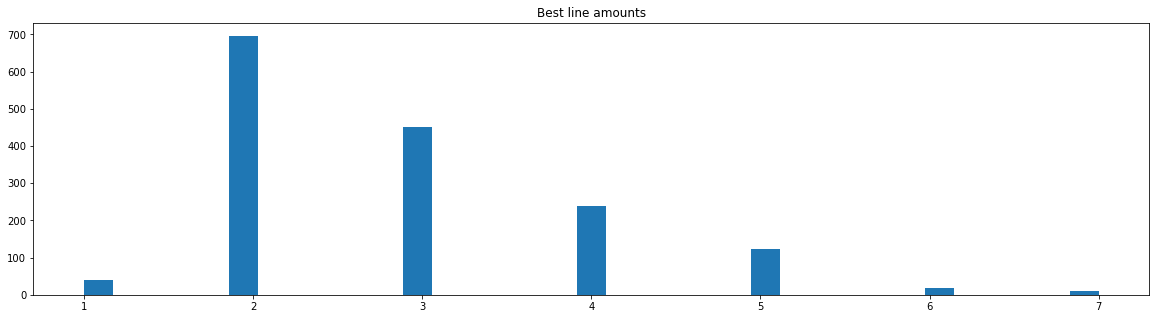

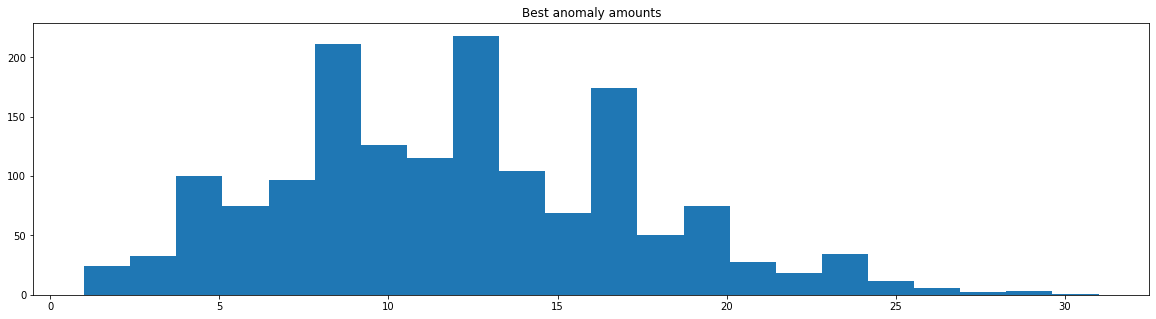

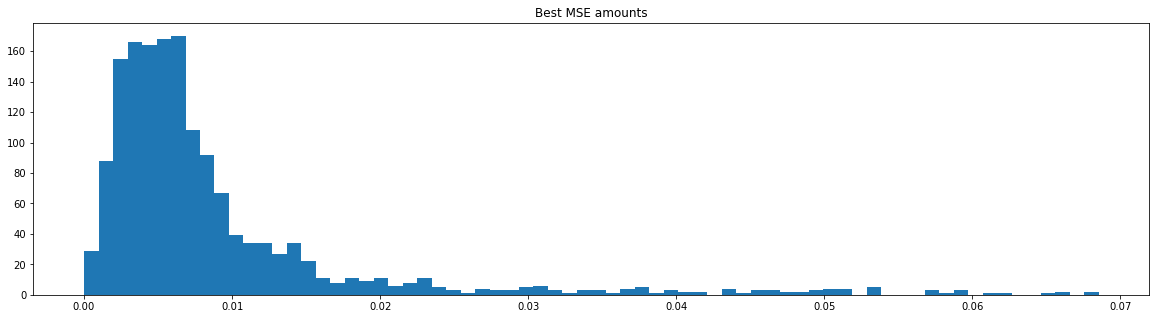

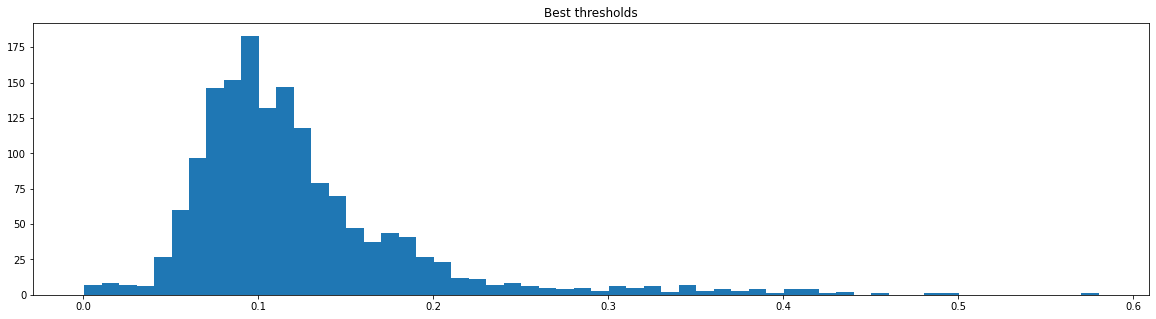

In [8]:
# histograms of the different stats
plt.title('Best line amounts')
plt.hist(best_line_amounts, bins='auto')
plt.show()

plt.title('Best anomaly amounts')
plt.hist(best_anomaly_amounts, bins='auto')
plt.show()

plt.title('Best MSE amounts')
plt.hist(best_mse_amounts, bins='auto')
plt.show()

plt.title('Best thresholds')
plt.hist(best_thresholds, bins='auto')
plt.show()

ETT for Huseby barnehage
Monday


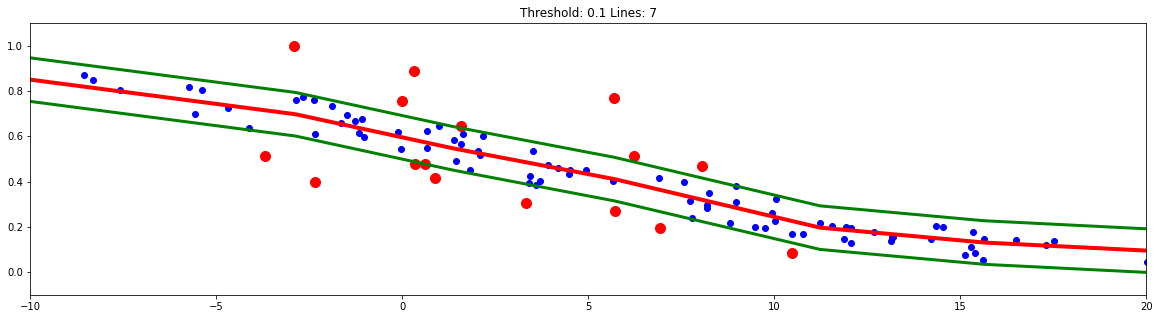

Tuesday


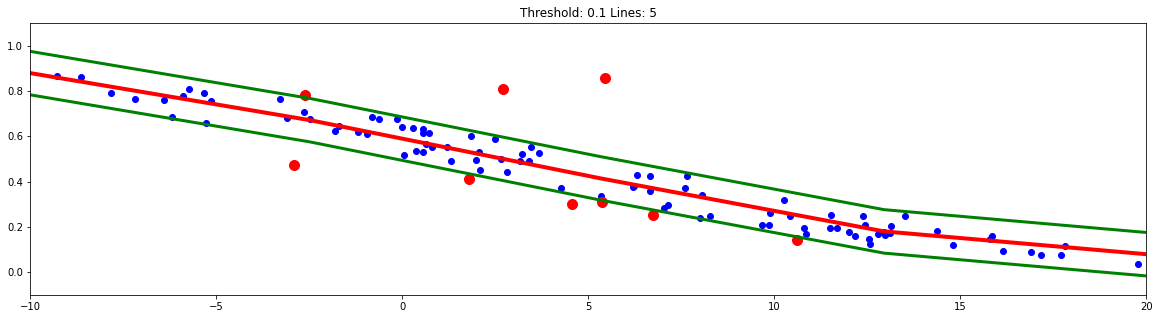

Wednesday


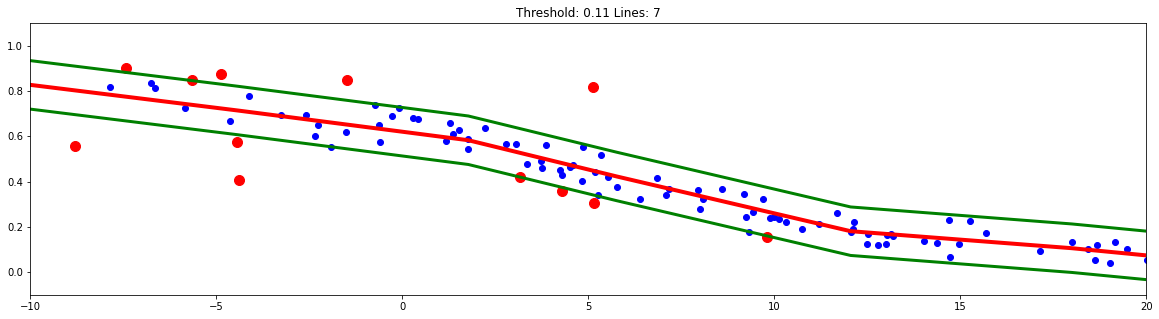

Thursday


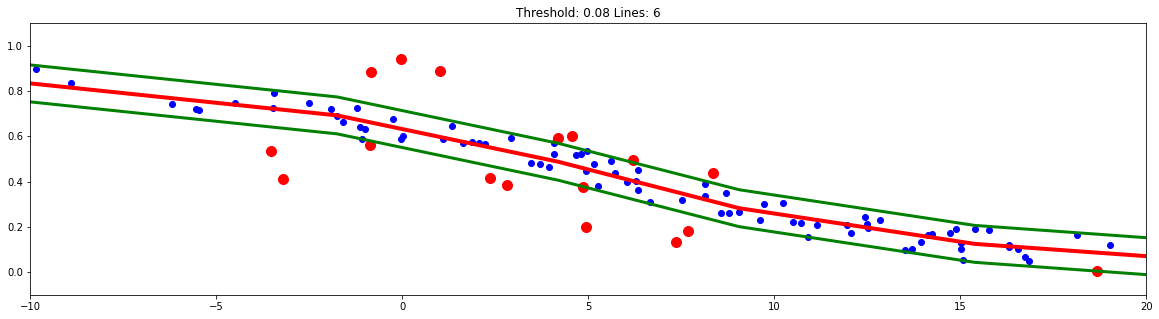

Friday


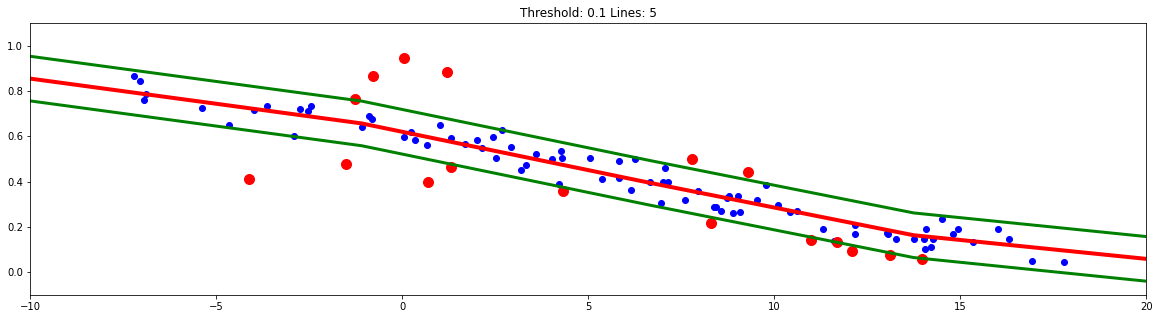

Saturday


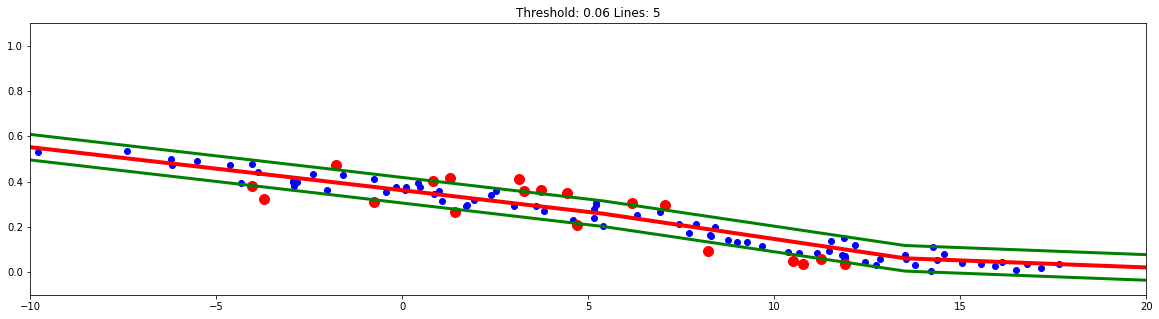

Sunday


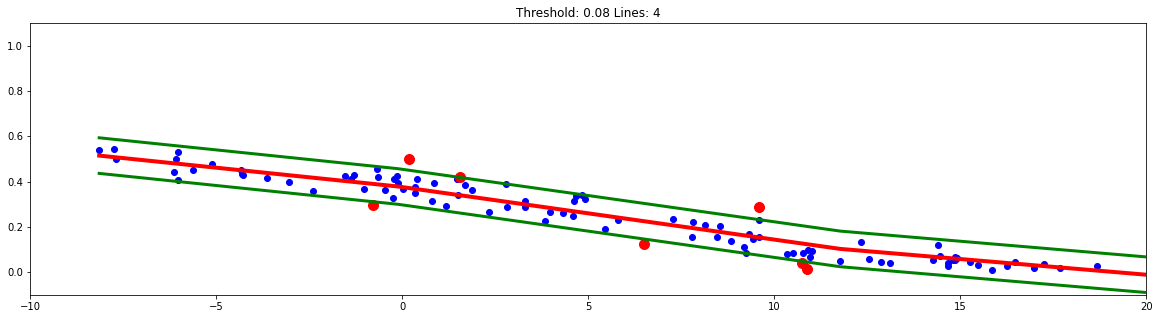

In [9]:
# plot the ETT of a random building
building_name = random.choice(list(ETTs.keys()))
ETT = ETTs[building_name]
print('ETT for ' + building_name)

# get energy usage of that building
building_energy = building_dfs[building_name]['Totalt']

# ETT consists of 7 graphs, one for each day of the week
for day, et in ETT.items():
    # get energy and temperature data for this day
    day_energy = building_energy.loc[building_energy.index.weekday == week_days.index(day)]
    day_temp = daily_temp.loc[daily_temp.index.weekday == week_days.index(day)]

    print(day)
    et.plot(day_energy, day_temp)